In [1]:
from keras import Sequential, Model
import numpy as np

from keras import Input
from keras import layers
from tensorflow.keras.optimizers import RMSprop

import sys
sys.path.append('..')

import ep.etools as apt


In [2]:
# import des données financières de Yahoo
import yfinance as yf
etf = ['BZ=F','EURUSD=X']
data = yf.Ticker(etf[0])

In [3]:
dataH = data.history(start='2007-01-01',period='1d')
# dataH

In [4]:
it = yf.download(tickers=etf, period='1d',start='2009-01-01')
it.describe()

[*********************100%***********************]  2 of 2 completed


Adj Close                     Close                      High  \
              BZ=F     EURUSD=X         BZ=F     EURUSD=X         BZ=F   
count  3324.000000  3498.000000  3324.000000  3498.000000  3324.000000   
mean     75.874856     1.228948    75.874856     1.228948    76.722515   
std      25.421813     0.116109    25.421813     0.116109    25.440649   
min      19.330000     1.037958    19.330000     1.037958    21.270000   
25%      55.357500     1.125201    55.357500     1.125201    56.070000   
50%      71.650002     1.202270    71.650002     1.202270    72.450001   
75%     103.462500     1.328661   103.462500     1.328661   104.302500   
max     127.980003     1.512791   127.980003     1.512791   137.000000   

                            Low                      Open               \
          EURUSD=X         BZ=F     EURUSD=X         BZ=F     EURUSD=X   
count  3498.000000  3324.000000  3498.000000  3324.000000  3498.000000   
mean      1.233323    74.949931     1.224374    75.851167     1.228978   
std       0.116828    25.350396     0.115677    25.394829     0.116196   
min       1.041938    16.000000     0.760572    19.559999     1.037958   
25%       1.129532    54.689999     1.121583    55.384999     1.125236   
50%       1.206702    70.680000     1.199062    71.590000     1.202219   
75%       1.334112   102.375002     1.323446   103.440002     1.328643   
max       1.514532   125.300003     1.504099   129.570007     1.512608   

             Volume           
               BZ=F EURUSD=X  
count   3324.000000   3498.0  
mean   17895.455174      0.0  
std    16678.534569      0.0  
min        0.000000      0.0  
25%      953.750000      0.0  
50%    16666.500000      0.0  
75%    30867.250000      0.0  
max    87185.000000      0.0

In [5]:
# supprime colonnes inutiles
it.drop(['High','Low','Open','Volume','Adj Close'],axis=1,inplace=True)
print(it.columns.to_list())
# it.rename(columns='_'.join,inplace=True)
it.columns = it.columns.map('_'.join)
it.rename(columns={'Close_BZ=F':'brent','Close_EURUSD=X':'FX'},inplace=True)
it.describe()

[('Close', 'BZ=F'), ('Close', 'EURUSD=X')]


,brent,FX
count,3324.000000,3498.000000
mean,75.874856,1.228948
std,25.421813,0.116109
min,19.330000,1.037958
25%,55.357500,1.125201
50%,71.650002,1.202270
75%,103.462500,1.328661
max,127.980003,1.512791


In [6]:
it.dropna(axis=0,inplace=True)
it.describe()

,brent,FX
count,3319.000000,3319.000000
mean,75.868680,1.227395
std,25.421004,0.115982
min,19.330000,1.037958
25%,55.355000,1.124727
50%,71.650002,1.195614
75%,103.439999,1.327457
max,127.980003,1.512791


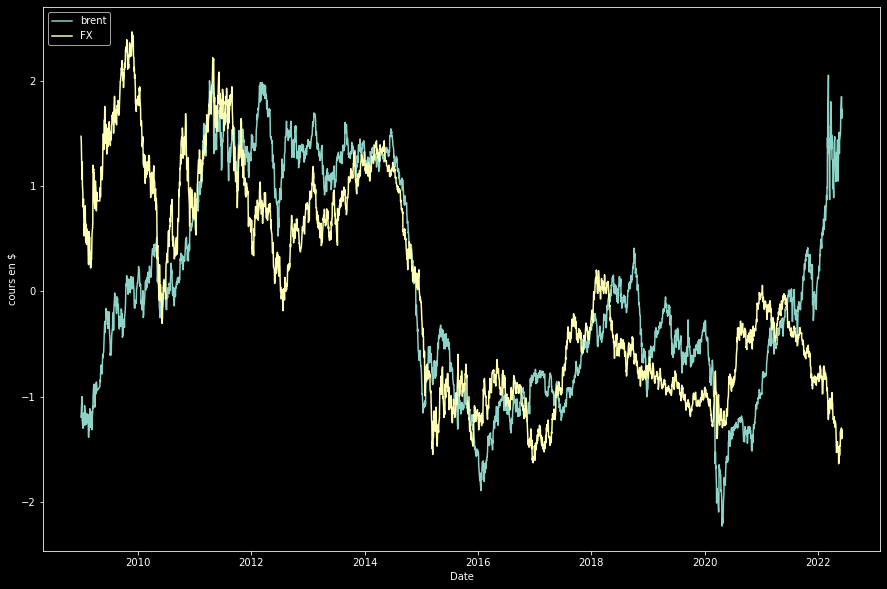

In [64]:
import matplotlib.pyplot as plt
it_plot = it.copy()
# normalisation
it_mean = it.mean(axis=0)
it_std = it.std(axis=0)
it_plot = (it_plot - it_mean) /it_std
# plot
plt.figure(figsize=(15,10))
plt.xlabel('Date')
plt.ylabel('cours en $')
plt.plot(it_plot,label=it_plot.columns.to_list())
plt.legend(loc='upper left')
plt.show()

In [8]:
# parametres
scale            = 1        # % du dataset (1=all)
train_prop       = .8       # ration du train vs test
sequence_len     = 8
batch_size       = 32
epochs           = 20
features         = ['brent','FX']
features_len     = len(features)

In [9]:
# Mise à l'échelle du dataFrame

df = it[:int(scale*len(it))].reset_index()
train_len=int(train_prop*len(df))

print(df)

# ---- Train / Test
dataset_train = df.loc[ :train_len-1, features ]
dataset_test  = df.loc[train_len:,    features ]
apt.subtitle('Train dataset :')
display(dataset_train.head(15))

# ---- Normalize, and convert to numpy array

mean = dataset_train.mean()
std  = dataset_train.std()
dataset_train = (dataset_train - mean) / std
dataset_test  = (dataset_test  - mean) / std

apt.subtitle('Après normalisation :')
display(dataset_train.describe().style.format("{0:.2f}"))

dataset_train = dataset_train.to_numpy()
dataset_test  = dataset_test.to_numpy()

apt.subtitle('Shapes :')
print('Dataset       : ',df.shape)
print('Train dataset : ',dataset_train.shape)
print('Test  dataset : ',dataset_test.shape)

           Date       brent        FX
0    2008-12-31   45.590000  1.397995
1    2009-01-02   46.910000  1.392292
2    2009-01-05   49.619999  1.364592
3    2009-01-06   50.529999  1.351004
4    2009-01-07   45.860001  1.361100
...         ...         ...       ...
3314 2022-05-27  119.430000  1.073295
3315 2022-05-31  122.839996  1.077354
3316 2022-06-01  122.610001  1.073411
3317 2022-06-02  117.610001  1.065417
3318 2022-06-03  119.720001  1.075107

[3319 rows x 3 columns]


<br>**Train dataset :**

,brent,FX
0,45.590000,1.397995
1,46.910000,1.392292
2,49.619999,1.364592
3,50.529999,1.351004
4,45.860001,1.361100
5,44.669998,1.369901
6,44.419998,1.345497
7,42.910000,1.336005
8,44.830002,1.320202
9,45.080002,1.321702


<br>**Après normalisation :**

,brent,FX
count,2655.00,2655.00
mean,-0.00,0.00
std,1.00,1.00
min,-2.00,-1.74
25%,-0.88,-0.97
50%,-0.18,0.06
75%,1.12,0.85
max,1.90,2.22


<br>**Shapes :**

Dataset       :  (3319, 3)
Train dataset :  (2655, 2)
Test  dataset :  (664, 2)


In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
# ---- Train generator

train_generator = TimeseriesGenerator(dataset_train, dataset_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(dataset_test,  dataset_test,  length=sequence_len,  batch_size=batch_size)

# ---- About

apt.subtitle('About the splitting of our dataset :')

x,y=train_generator[0]
print(f'Nombre de train batchs disponibles : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

x,y=train_generator[0]
apt.subtitle('What a batch looks like (x[0]) :')
apt.np_print(x[0] )
apt.subtitle('What a batch looks like (y[0]) :')
apt.np_print(y[0])

<br>**About the splitting of our dataset :**

Nombre de train batchs disponibles :  83
batch x shape :  (32, 8, 2)
batch y shape :  (32, 2)


<br>**What a batch looks like (x[0]) :**

[[-1.304  1.26 ]
 [-1.252  1.213]
 [-1.145  0.981]
 [-1.109  0.867]
 [-1.293  0.952]
 [-1.34   1.025]
 [-1.35   0.821]
 [-1.41   0.742]]


<br>**What a batch looks like (y[0]) :**

[-1.334  0.61 ]


In [12]:
# tf.config.get_visible_devices()
# tf.config.PhysicalDevice('CPU:0','CPU')

In [13]:
print(tf.__version__)

2.9.0


In [14]:
run_dir = './run/'
save_dir = f'{run_dir}/best_model.h5'
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

In [54]:
# le model Keras
input_data = Input(shape=(sequence_len,features_len))
# x = layers.GRU(200, dropout=0.2,return_sequences=True, recurrent_dropout=0.5)(input_data)
x = layers.LSTM(units=128,return_sequences=True)(input_data)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units=128,return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(units=64,return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(units=64,return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
x = layers.LSTM(units=64,return_sequences=True)(x)
x = layers.Dropout(0.3)(x)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5,activation='relu')(x)
x = layers.LSTM(units=32)(x)
x = layers.Dropout(0.1)(x)
# x = layers.LSTM(128,return_sequences=True)(x)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5, return_sequences=True)(x)
# x = layers.GRU(32, dropout=0.2,recurrent_dropout=0.5,activation='relu')(x)
# x = layers.Dense(256,activation='relu')(x)
# x = layers.Dropout(0.5)(x)
x = layers.Dense(32,activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_data = layers.Dense(features_len)(x)
# with tf.device("/cpu:0"):
model = Model(input_data,output_data)
    # model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['mae'])
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
# model.compile(optimizer=RMSprop(),loss='mse',metrics=['mae'])
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8, 2)]            0         
                                                                 
 lstm_29 (LSTM)              (None, 8, 128)            67072     
                                                                 
 dropout_32 (Dropout)        (None, 8, 128)            0         
                                                                 
 lstm_30 (LSTM)              (None, 8, 128)            131584    
                                                                 
 dropout_33 (Dropout)        (None, 8, 128)            0         
                                                                 
 lstm_31 (LSTM)              (None, 8, 64)             49408     
                                                                 
 dropout_34 (Dropout)        (None, 8, 64)             0   

In [55]:
# input_data = Input(shape=(sequence_len,features_len))
# x1 = layers.LSTM(100, activation='relu')(input_data)
# x2 = layers.Conv1D()(input_data)
# x2 = layers.MaxPooling1D()(x2)
# x3 = layers.Conv1D()(x2)
# x3 = layers.MaxPooling1D()(x3)


In [56]:
# with tf.device("/device:cpu:0"):
history = model.fit(train_generator,epochs=epochs,validation_data=test_generator,verbose=1,use_multiprocessing=True,callbacks = [bestmodel_callback])

Epoch 1/20
83/83 [==============================] - 9s 46ms/step - loss: 0.5070 - mae: 0.5692 - val_loss: 0.4261 - val_mae: 0.4634
Epoch 2/20
83/83 [==============================] - 5s 38ms/step - loss: 0.2638 - mae: 0.3955 - val_loss: 0.3651 - val_mae: 0.4466
Epoch 3/20
83/83 [==============================] - 4s 38ms/step - loss: 0.2170 - mae: 0.3616 - val_loss: 0.2797 - val_mae: 0.4019
Epoch 4/20
83/83 [==============================] - 4s 38ms/step - loss: 0.1874 - mae: 0.3303 - val_loss: 0.2733 - val_mae: 0.3713
Epoch 5/20
83/83 [==============================] - 5s 39ms/step - loss: 0.1475 - mae: 0.3035 - val_loss: 0.2424 - val_mae: 0.3451
Epoch 6/20
83/83 [==============================] - 4s 38ms/step - loss: 0.1275 - mae: 0.2767 - val_loss: 0.1504 - val_mae: 0.2744
Epoch 7/20
83/83 [==============================] - 4s 38ms/step - loss: 0.0993 - mae: 0.2431 - val_loss: 0.1409 - val_mae: 0.2716
Epoch 8/20
83/83 [==============================] - 4s 38ms/step - loss: 0.1028 - m

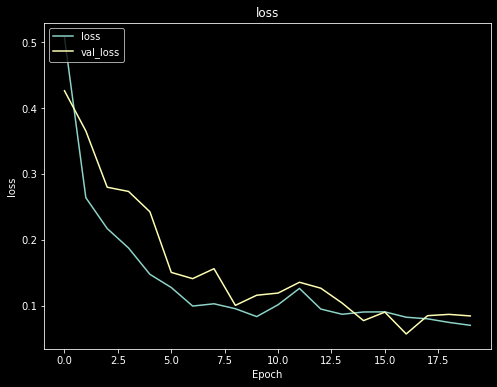

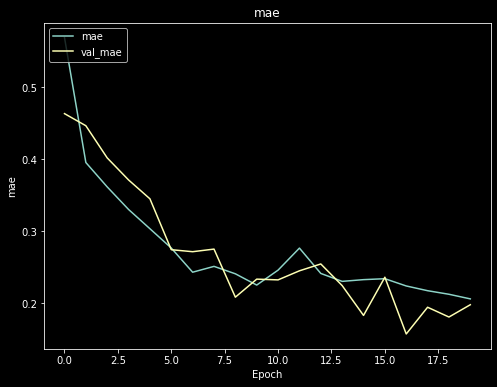

In [57]:
apt.plot_history(history,plot={'loss':['loss','val_loss'], 'mae':['mae','val_mae']}, save_as='01-history')

In [58]:
best_model = tf.keras.models.load_model(f'{run_dir}/best_model.h5')

8 594 656 2655
1/1 [==============================] - 0s 10ms/step
[[94.0945     1.1556399]]


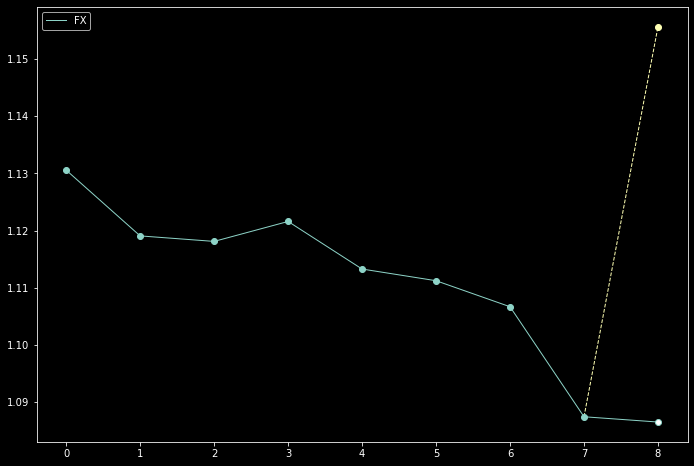

Gap between prediction and reality : 0.07 u


In [60]:
import math,random
def denormalize(mean,std,seq):
    nseq = seq.copy()
    for i,s in enumerate(nseq):
        s = s*std + mean
        nseq[i]=s
    return nseq


# ---- Get a sequence

i=random.randint(0,len(dataset_test)-sequence_len)
j = len(dataset_test)-sequence_len
sequence      = dataset_test[i:i+sequence_len]
sequence_true = dataset_test[i:i+sequence_len+1]
print(sequence_len,i,j,len(dataset_train))

# ---- Prediction

pred = best_model.predict( np.array([sequence]) )

# ---- De-normalization

sequence_true = denormalize(mean,std, sequence_true)
pred          = denormalize(mean,std, pred)

print(pred)
# ---- Show it
feat=1

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

delta=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta:.2f} u')

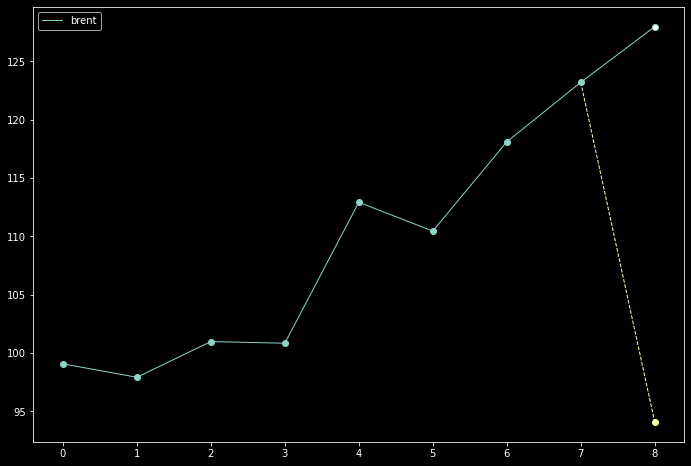

Gap between prediction and reality : 33.89 u


In [61]:
feat=0

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features, only_features=[feat],width=14, height=8)

delta=abs(sequence_true[-1][feat]-pred[-1][feat])
print(f'Gap between prediction and reality : {delta:.2f} u')

In [62]:
def get_prediction(dataset, model, iterations=4,sequence_len=16):

    # ---- Initial sequence

    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate

    sequence_pred=list(sequence_pred)

    for i in range(iterations):
        sequence=sequence_pred[-sequence_len:]
        pred = model.predict( np.array([sequence]) )
        sequence_pred.append(pred[0])

    # ---- Extract the predictions    

    pred=np.array(sequence_pred[-iterations:])

    # ---- De-normalization

    sequence_true = denormalize(mean,std, sequence_true)
    pred          = denormalize(mean,std, pred)

    return sequence_true,pred

1/1 [==============================] - 0s 10ms/step


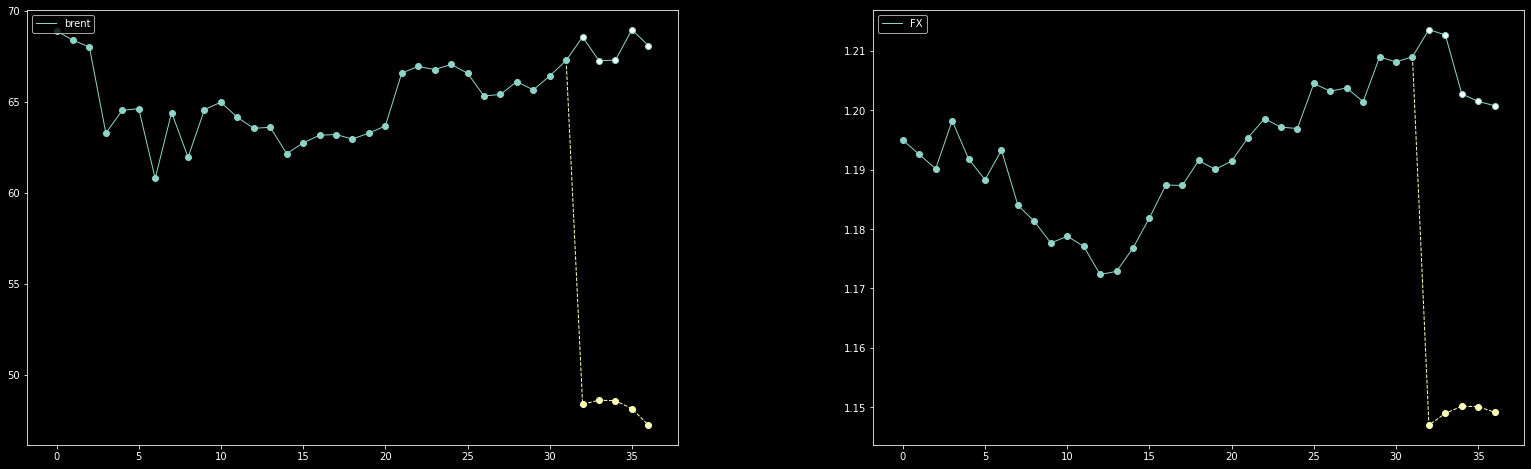

In [63]:
sequence_true, pred = get_prediction(dataset_test, best_model,iterations=5,sequence_len=32)

feat=[0,1]

apt.plot_multivariate_serie(sequence_true, predictions=pred, labels=features,
                            only_features=feat,width=14, height=8)